In [4]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

def calc_mm_model(true_model_coefficients, x, args = None):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    true_model_coefficients: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    args: dict, extra arguments to pass to the function. Default None
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    assert len(true_model_coefficients) == 4, "true_model_coefficients must be length 4"
    t1, t2, t3, t4 = true_model_coefficients
    
    #If array is not 2D, give it shape (len(array), 1)
    if not len(x.shape) > 1:
        x = x.reshape(-1,1)

    assert x.shape[0] == 2, "Isotherm x_data must be 2 dimensional"
    x1, x2 = x #Split x into 2 parts by splitting the rows

    y_model =  (t3/t1)*(np.exp(-t1*x1)*(1-np.exp(-t1*x2))) + (t4/t2)*(np.exp(-t2*x1)*(1-np.exp(-t2*x2)))
    
    return y_model

In [36]:
%%time

param_name_str = "t1t2t3t4"
indeces_to_consider = [0,1,2,3]

theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4']
bounds_x_l = [0, 5]
bounds_x_u = [105, 15]

bounds_theta_l = [0.075, 0.01, 1450, 400]
bounds_theta_u = [0.5, 0.1, 1550, 500]
theta_ref = np.array([0.154, 0.030, 1506.0, 472.0]) 
bounds_x = np.array([bounds_x_l, bounds_x_u])

theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

# This generates experimental data points
num_points = 5
Xexp = grid_sampling(num_points, bounds_x)
# Xexp = np.array([[0,5,30,45,60,75,90],[5,25,15,15,15,15,30]]).T
print(Xexp)
Yexp_org = np.array([7518,11264,2580,1485,861,561,663])
# Evaluate model and add noise based on assumed theta values
Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i])  for i in range(len(Xexp)) ]).flatten()
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = 1)
Yexp = Yexp_org + noise

[[  0.     5.  ]
 [  0.     7.5 ]
 [  0.    10.  ]
 [  0.    12.5 ]
 [  0.    15.  ]
 [ 26.25   5.  ]
 [ 26.25   7.5 ]
 [ 26.25  10.  ]
 [ 26.25  12.5 ]
 [ 26.25  15.  ]
 [ 52.5    5.  ]
 [ 52.5    7.5 ]
 [ 52.5   10.  ]
 [ 52.5   12.5 ]
 [ 52.5   15.  ]
 [ 78.75   5.  ]
 [ 78.75   7.5 ]
 [ 78.75  10.  ]
 [ 78.75  12.5 ]
 [ 78.75  15.  ]
 [105.     5.  ]
 [105.     7.5 ]
 [105.    10.  ]
 [105.    12.5 ]
 [105.    15.  ]]
CPU times: total: 31.2 ms
Wall time: 2.99 ms


In [37]:
## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess        
        y = calc_mm_model(model_coefficients, x[i])
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i])
        y_data.append(y)
        # print(model_coefficients, x[i], y) 
    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

# print(model(theta_true, theta_ref, Xexp, indeces_to_consider))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    # print(y.flatten())
    # print(model(theta_guess, theta_ref, x, indeces_to_consider).flatten())
    error = y.flatten() - model(theta_guess, theta_ref, x, indeces_to_consider).flatten() #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(theta_true, theta_ref, Xexp, indeces_to_consider, Yexp))
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

93.91212749865004 14509.840166547998


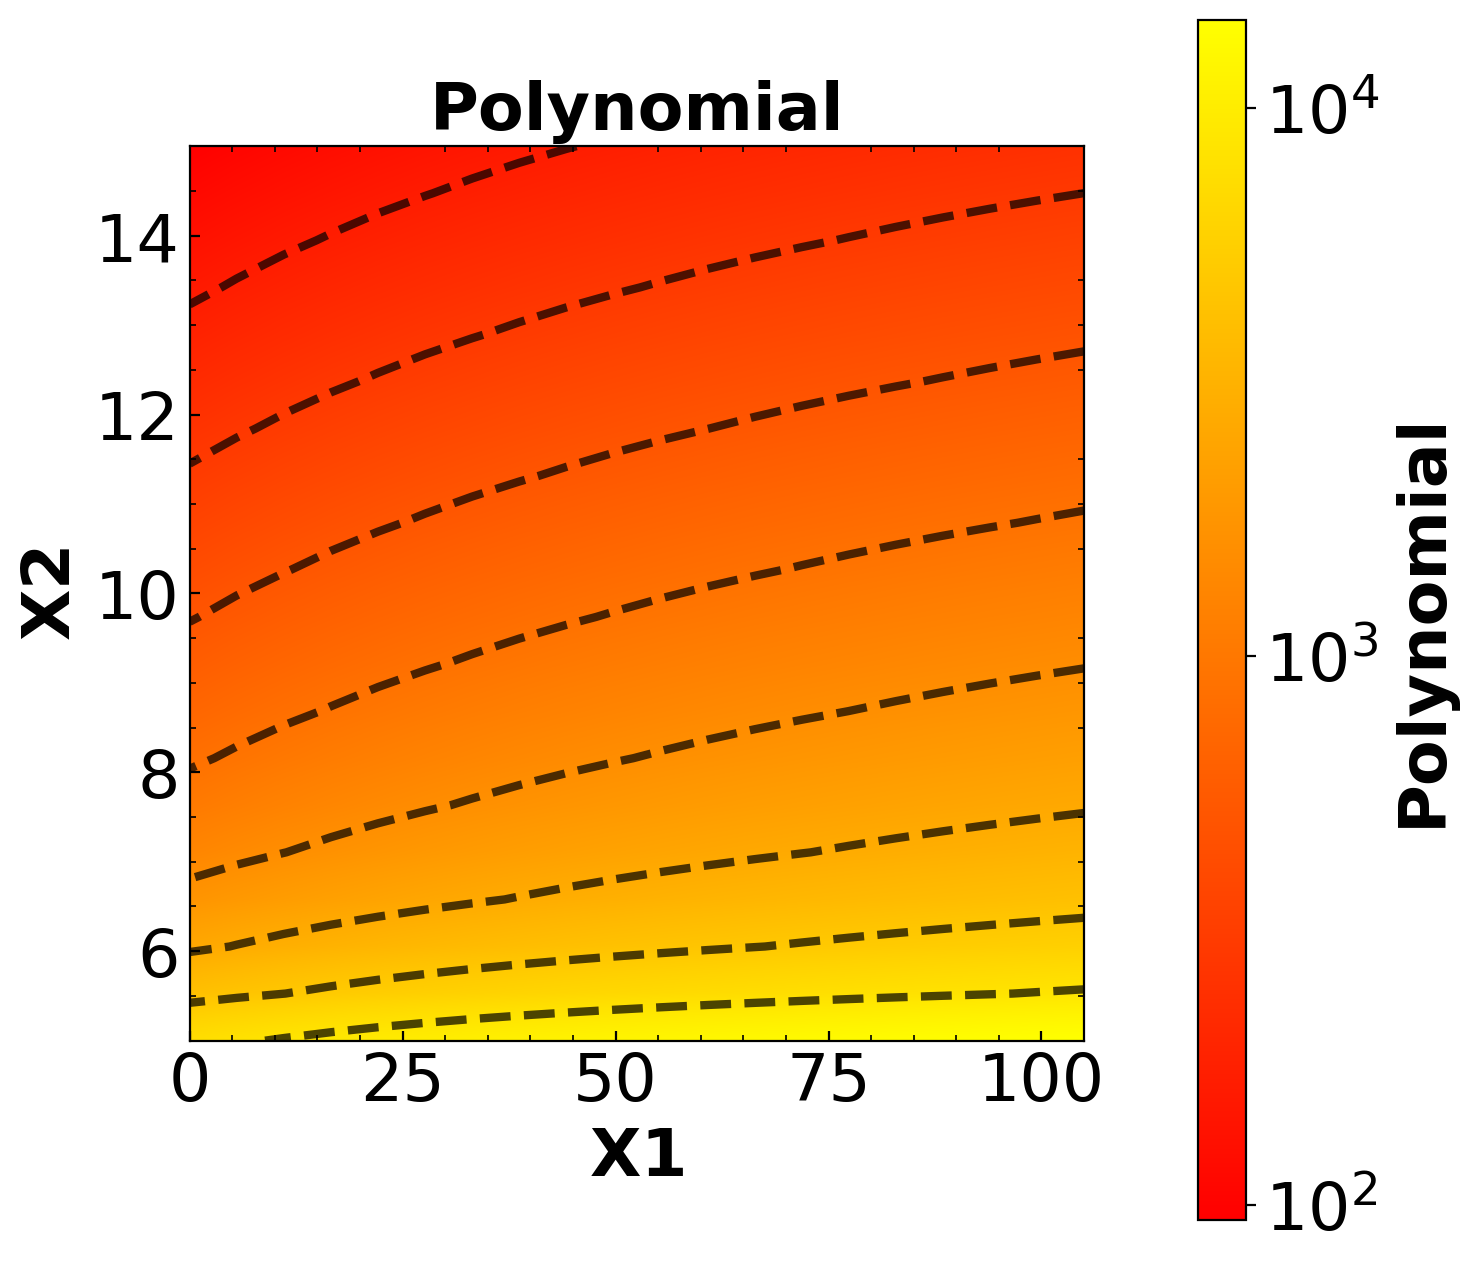

In [38]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(bounds_x_l[0],bounds_x_u[0],len_mesh_data)
x2 = np.linspace(bounds_x_l[1],bounds_x_u[1],len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
X_mesh_reshape = np.array(X_mesh).reshape(2,-1).T
# #Creates an array for Y that will be filled with the for loop

#Calculate y_sim
Y =  [ calc_mm_model(theta_ref, X_mesh_reshape[i]) for i in range(len(X_mesh_reshape)) ] 
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
param_names = ["X1", "X2"]
levels = [100]
idcs_to_plot = [0]
zz = np.array(Y).reshape(len_mesh_data,-1).T
z = np.array([zz])
z_titles = ["Polynomial"]

plot_dict = make_plot_dict(False, None, None, None, levels, save_path=None)
plot_nlr_heat_maps(X_mesh, z, None, None, z_titles, param_names, idcs_to_plot, plot_dict)

In [39]:
## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper) 

## specify initial guesses
theta_guess = np.random.uniform(low=lower, high=upper, size= len(lower) )
print("theta_guess", theta_guess)
Solution = optimize.least_squares(regression_func, theta_guess ,bounds=bounds, method='trf',
                                    args=(theta_ref, Xexp, indeces_to_consider, Yexp),verbose=0)

nlr_theta = Solution.x
print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_ref, Xexp, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

theta_guess [1.65577900e-01 9.91557050e-02 1.47800951e+03 4.47823900e+02]
Best Theta =  [1.53923437e-01 2.99724564e-02 1.50673705e+03 4.71307403e+02]
theta_ref [1.540e-01 3.000e-02 1.506e+03 4.720e+02]
SSE =  25.456373316711776


93.91212749865004 14510.140502993476


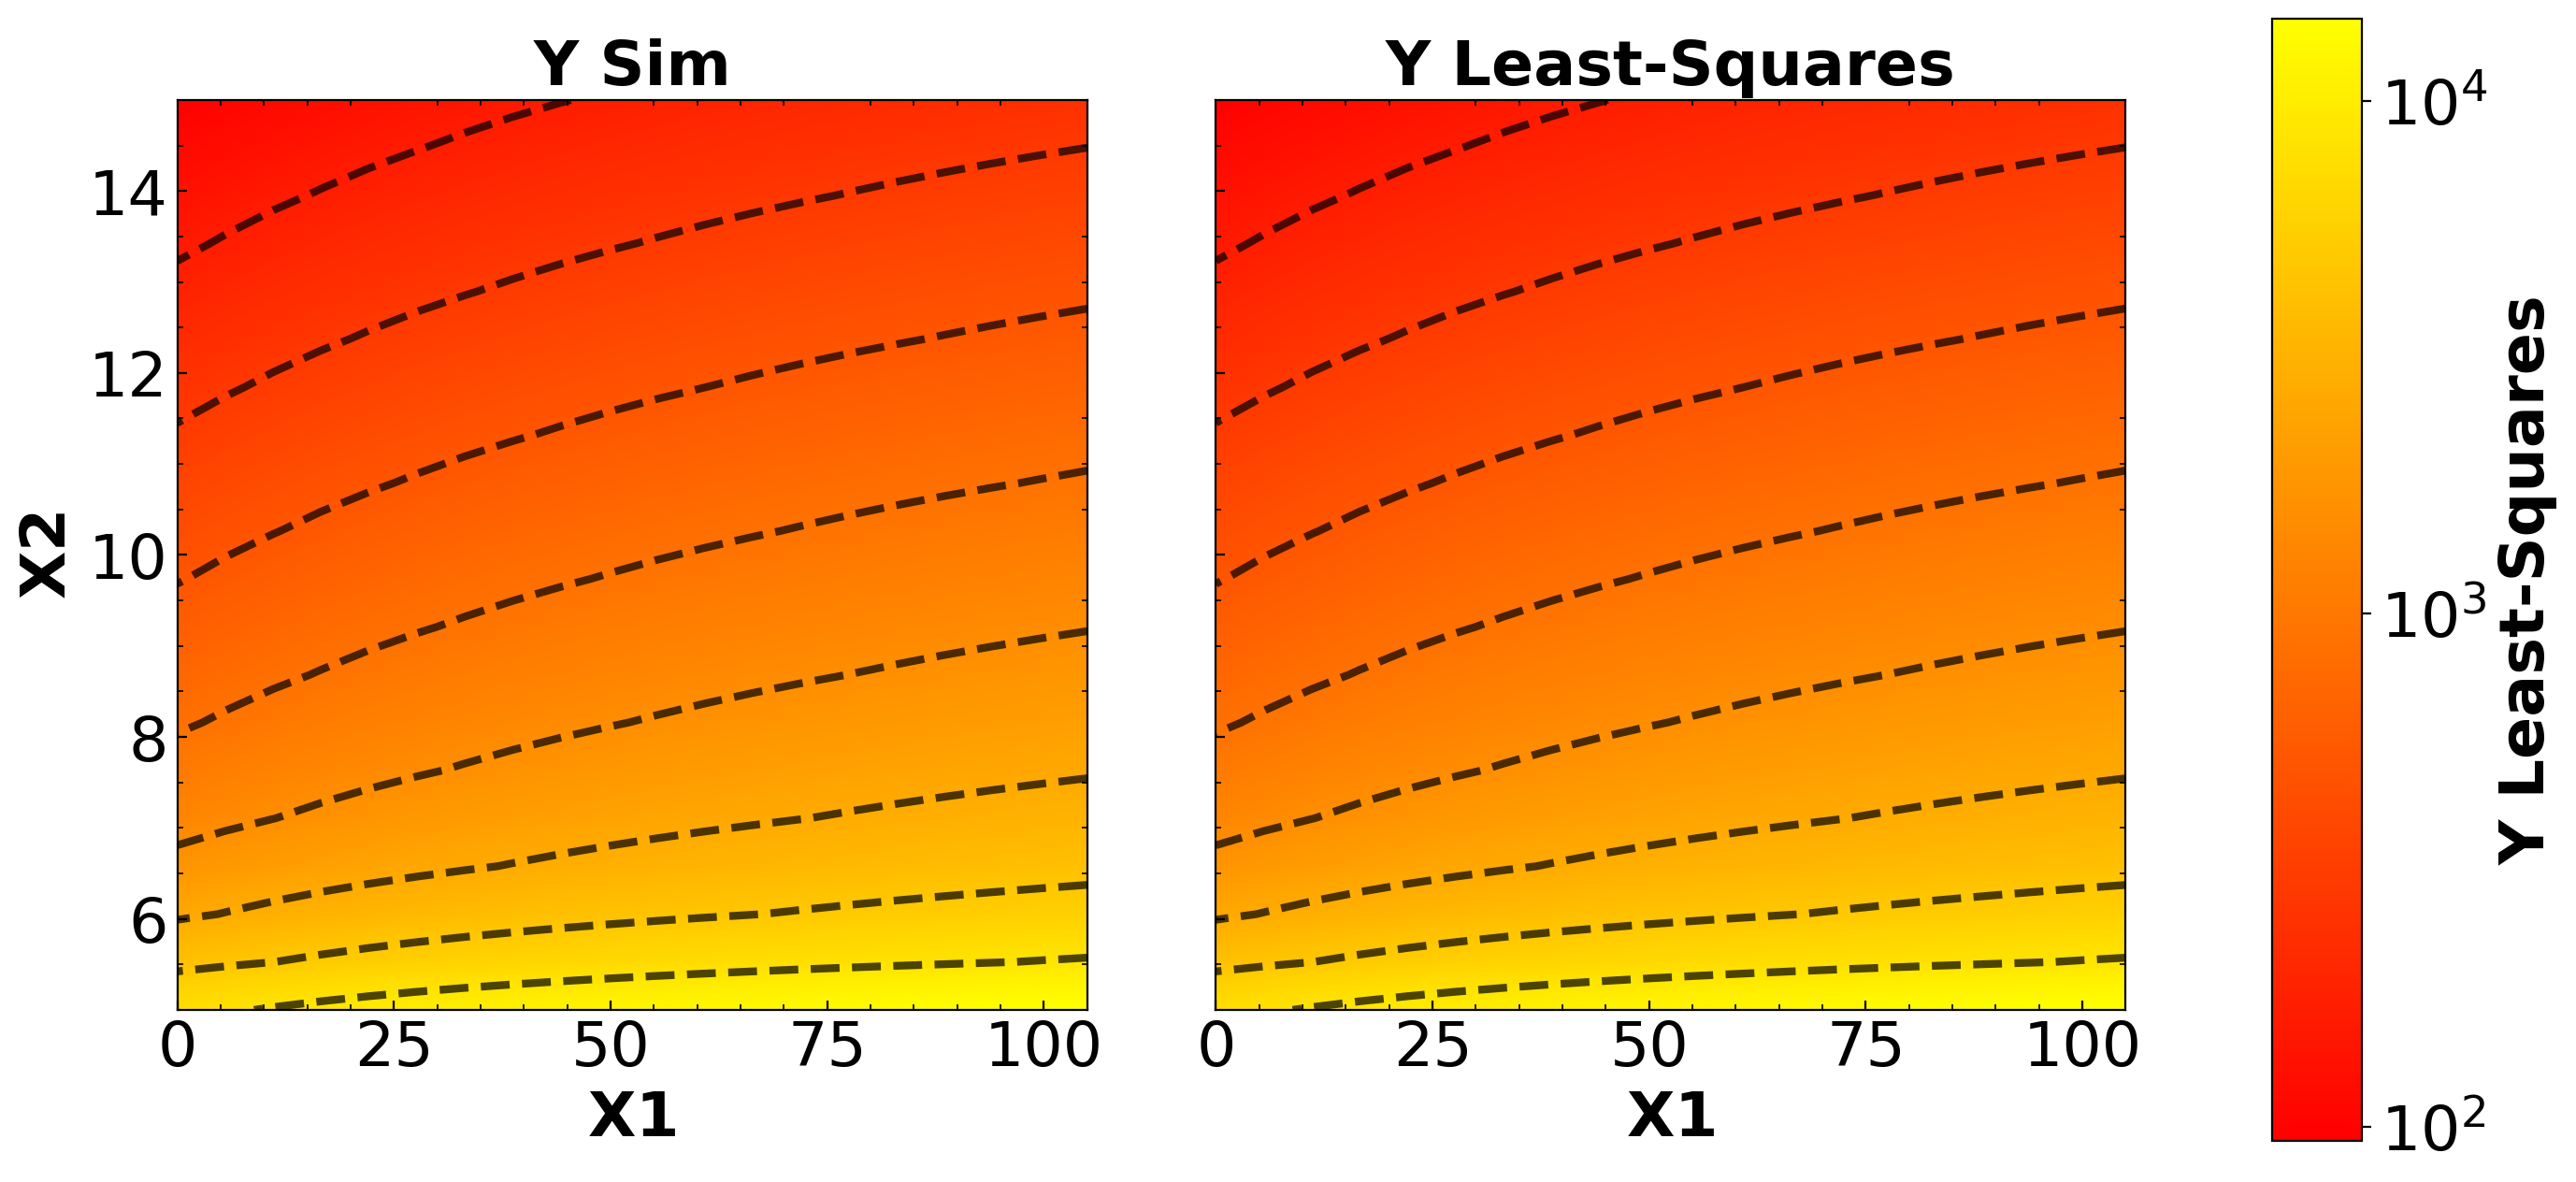

In [40]:
##New Cell
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
X_mesh_reshape = np.array(X_mesh).reshape(2,-1).T
# #Creates an array for Y that will be filled with the for loop

#Calculate y_sim
Y_nlr = model(nlr_theta, theta_ref, X_mesh_reshape, indeces_to_consider)
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
param_names = ["X1", "X2"]
levels = [100]
idcs_to_plot = [0]
y_sim = np.array(Y).reshape(len_mesh_data,-1).T
y_nlr = np.array(Y_nlr).reshape(len_mesh_data,-1).T
z = np.array([y_sim, y_nlr])
z_titles = ["Y Sim", "Y Least-Squares"]
xbins = 5
ybins = 5
zbins = 900
title= None

plot_dict = make_plot_dict(False, None, None, None, levels, save_path=None)
plot_nlr_heat_maps(X_mesh, z, None, None, z_titles, param_names, idcs_to_plot, plot_dict)

SSE =  25.456373316711776


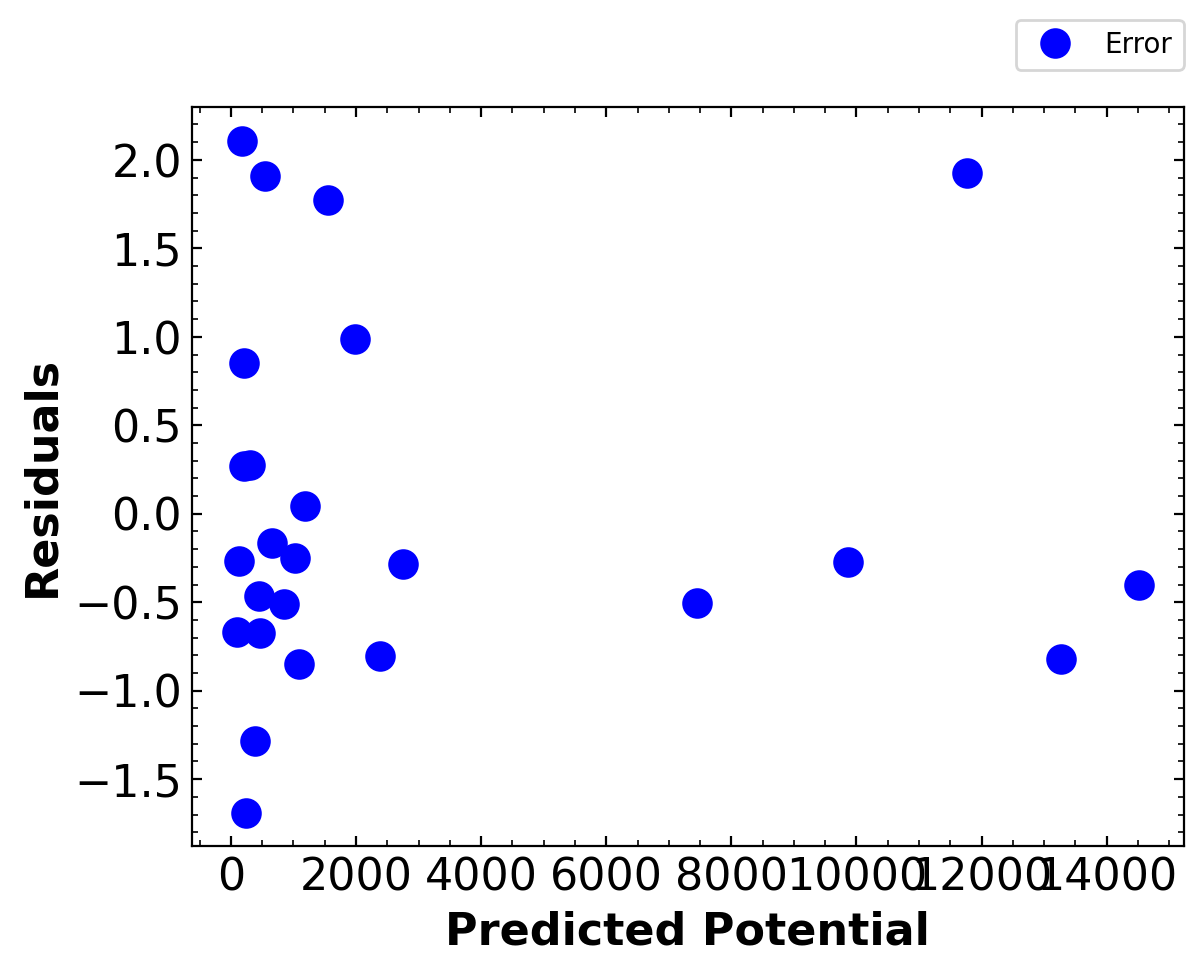

In [41]:
#Plot error
Y_nlr_exp = model(nlr_theta, theta_ref, Xexp, indeces_to_consider)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp, error,"b.",markersize=20, label = "Error")

plt.legend(fontsize=10,bbox_to_anchor=(0, 1.05, 1, 0.2),borderaxespad=0, loc = "lower right")

plt.minorticks_on() # turn on minor ticks
plt.tick_params(direction="in",top=True, right=True) 
plt.tick_params(which="minor",direction="in",top=True, right=True)

plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(False)

# plt.title("Residuals")
plt.xlabel('Predicted Potential', fontsize=16,fontweight='bold')
plt.ylabel('Residuals', fontsize=16,fontweight='bold')
plt.show()

In [42]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = len(theta_true_names)
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_true), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())
# print(heat_map_data_dict[hm_data_keys[0]].shape)

12.946244719508426 19.06979191197108


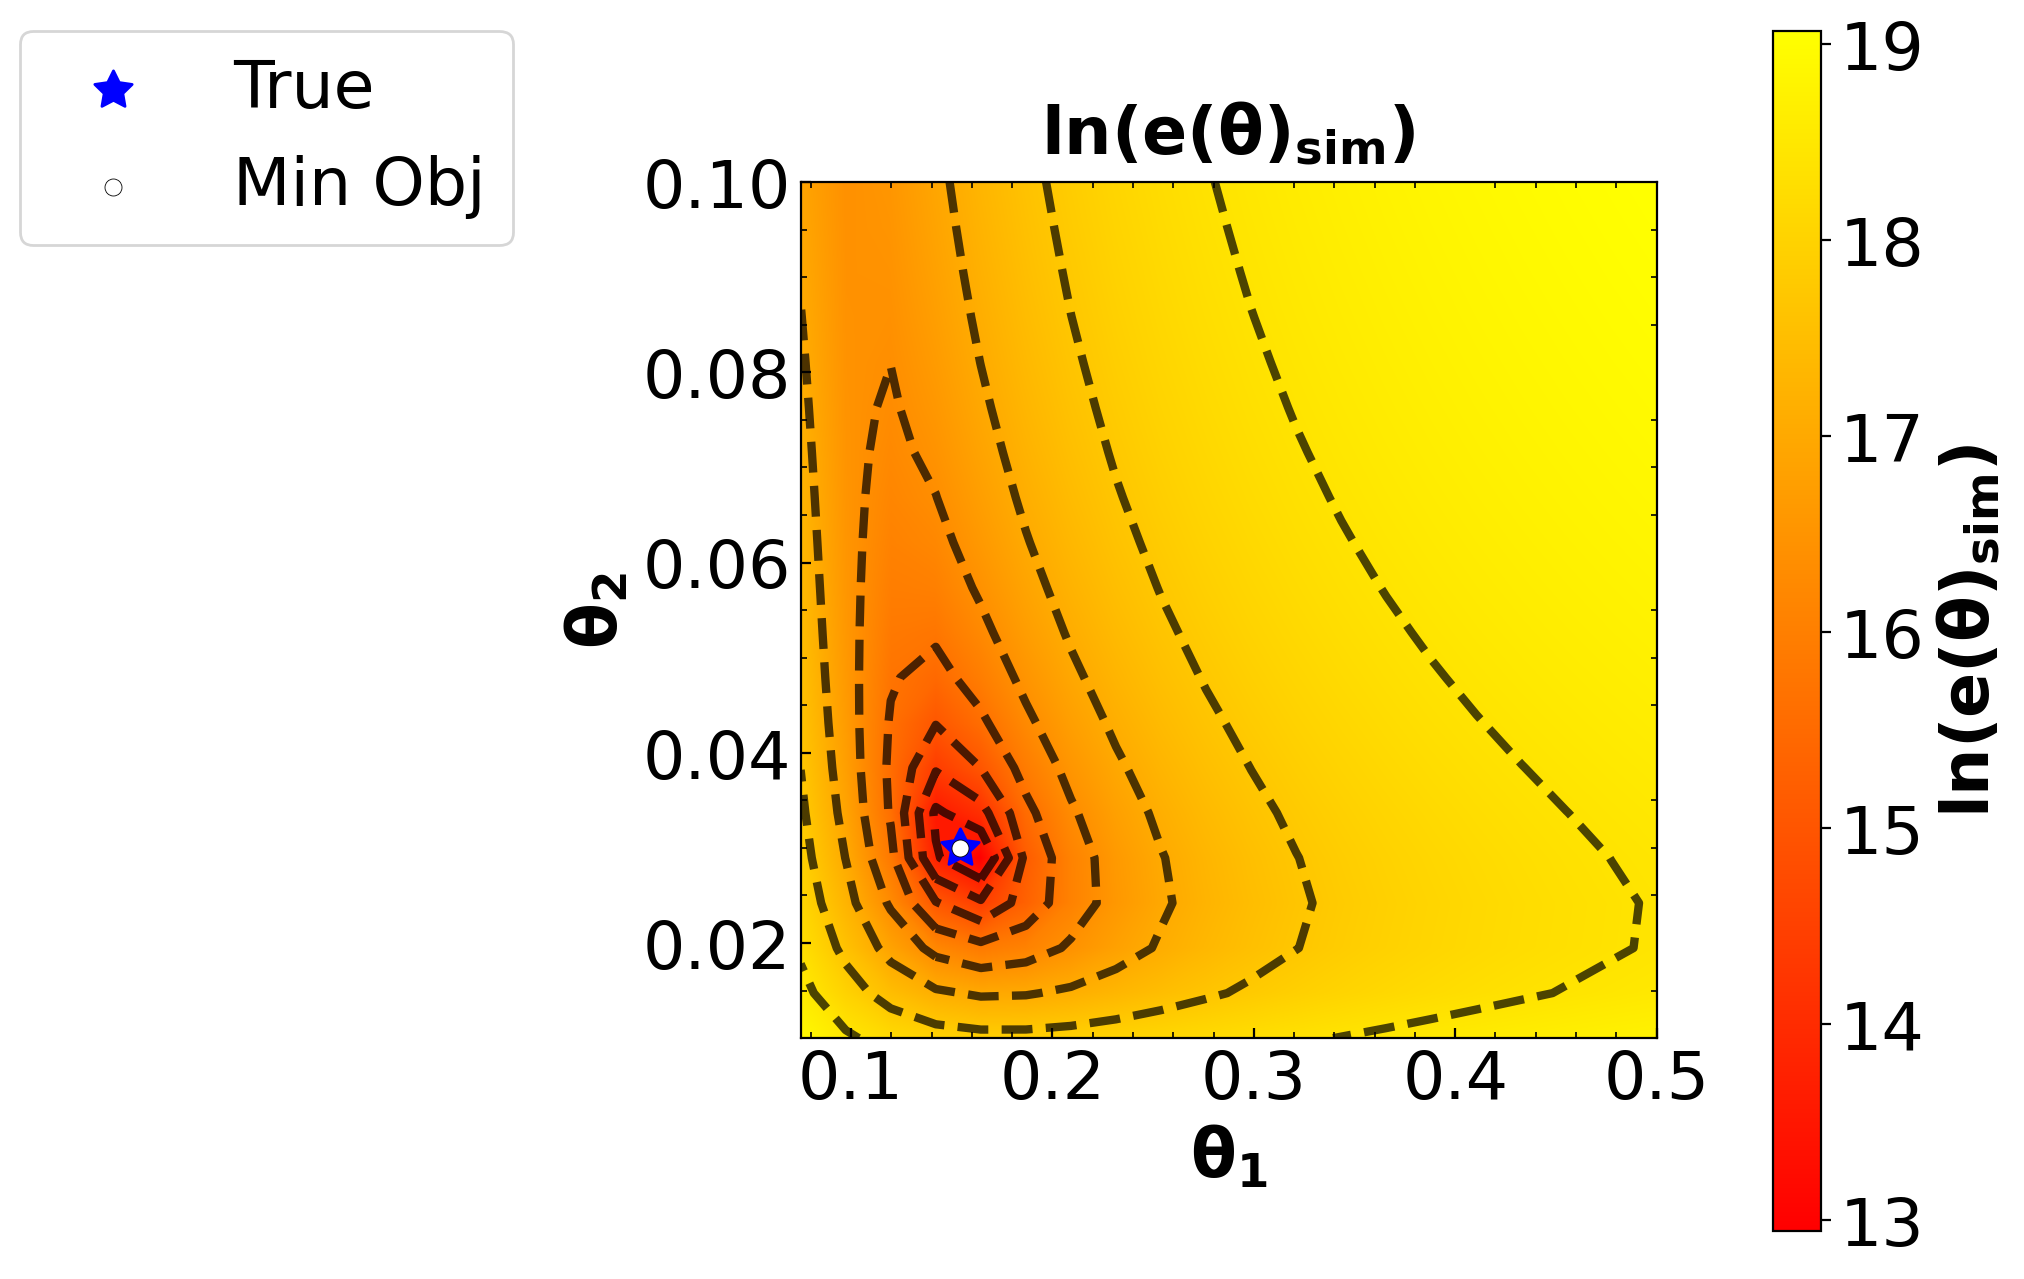

11.080868963622613 18.511824406045083


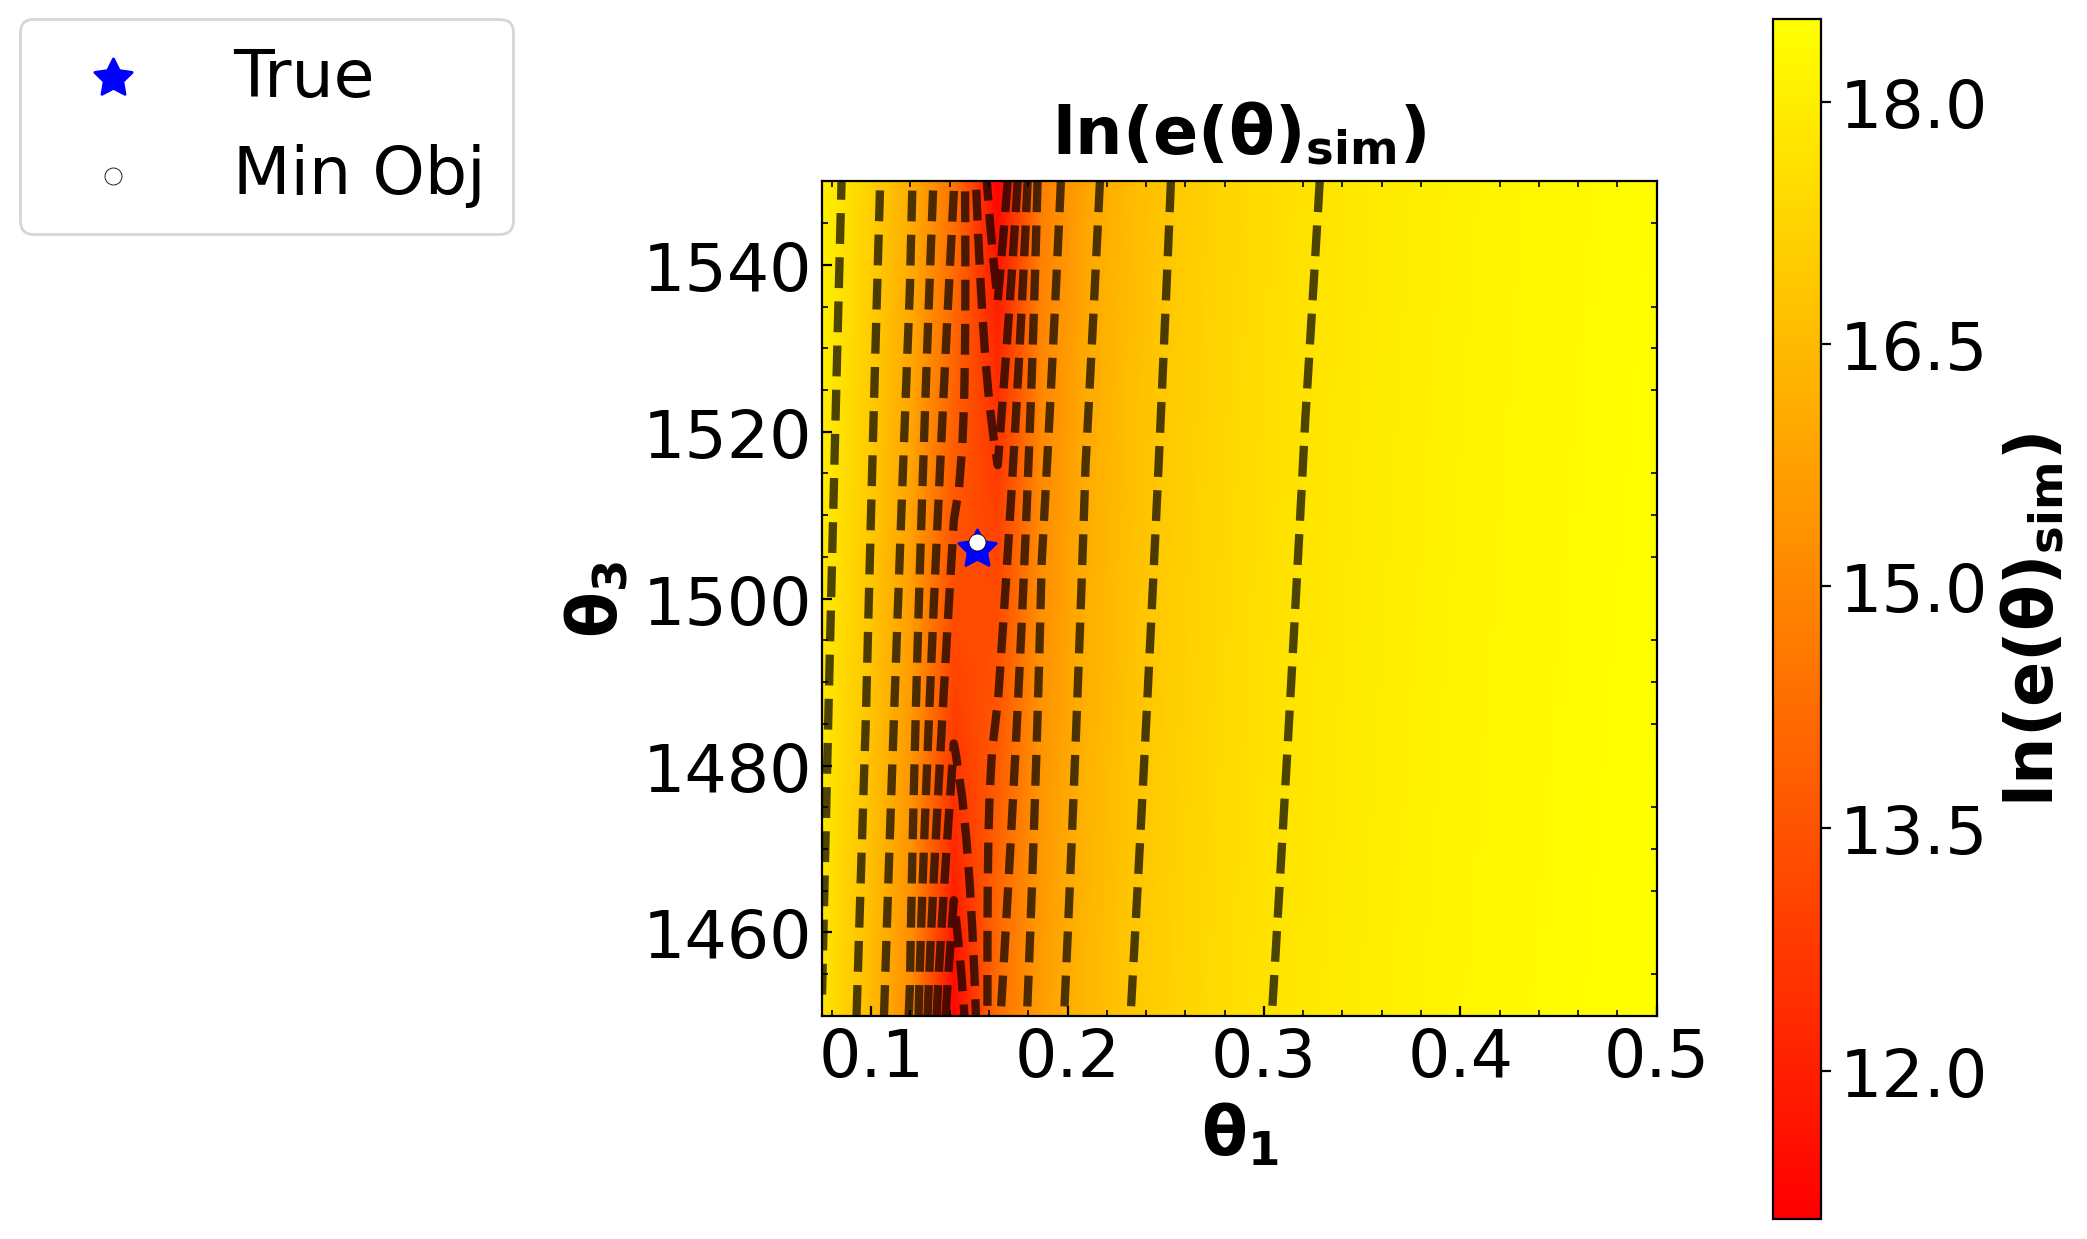

11.075707162556544 18.73420489353059


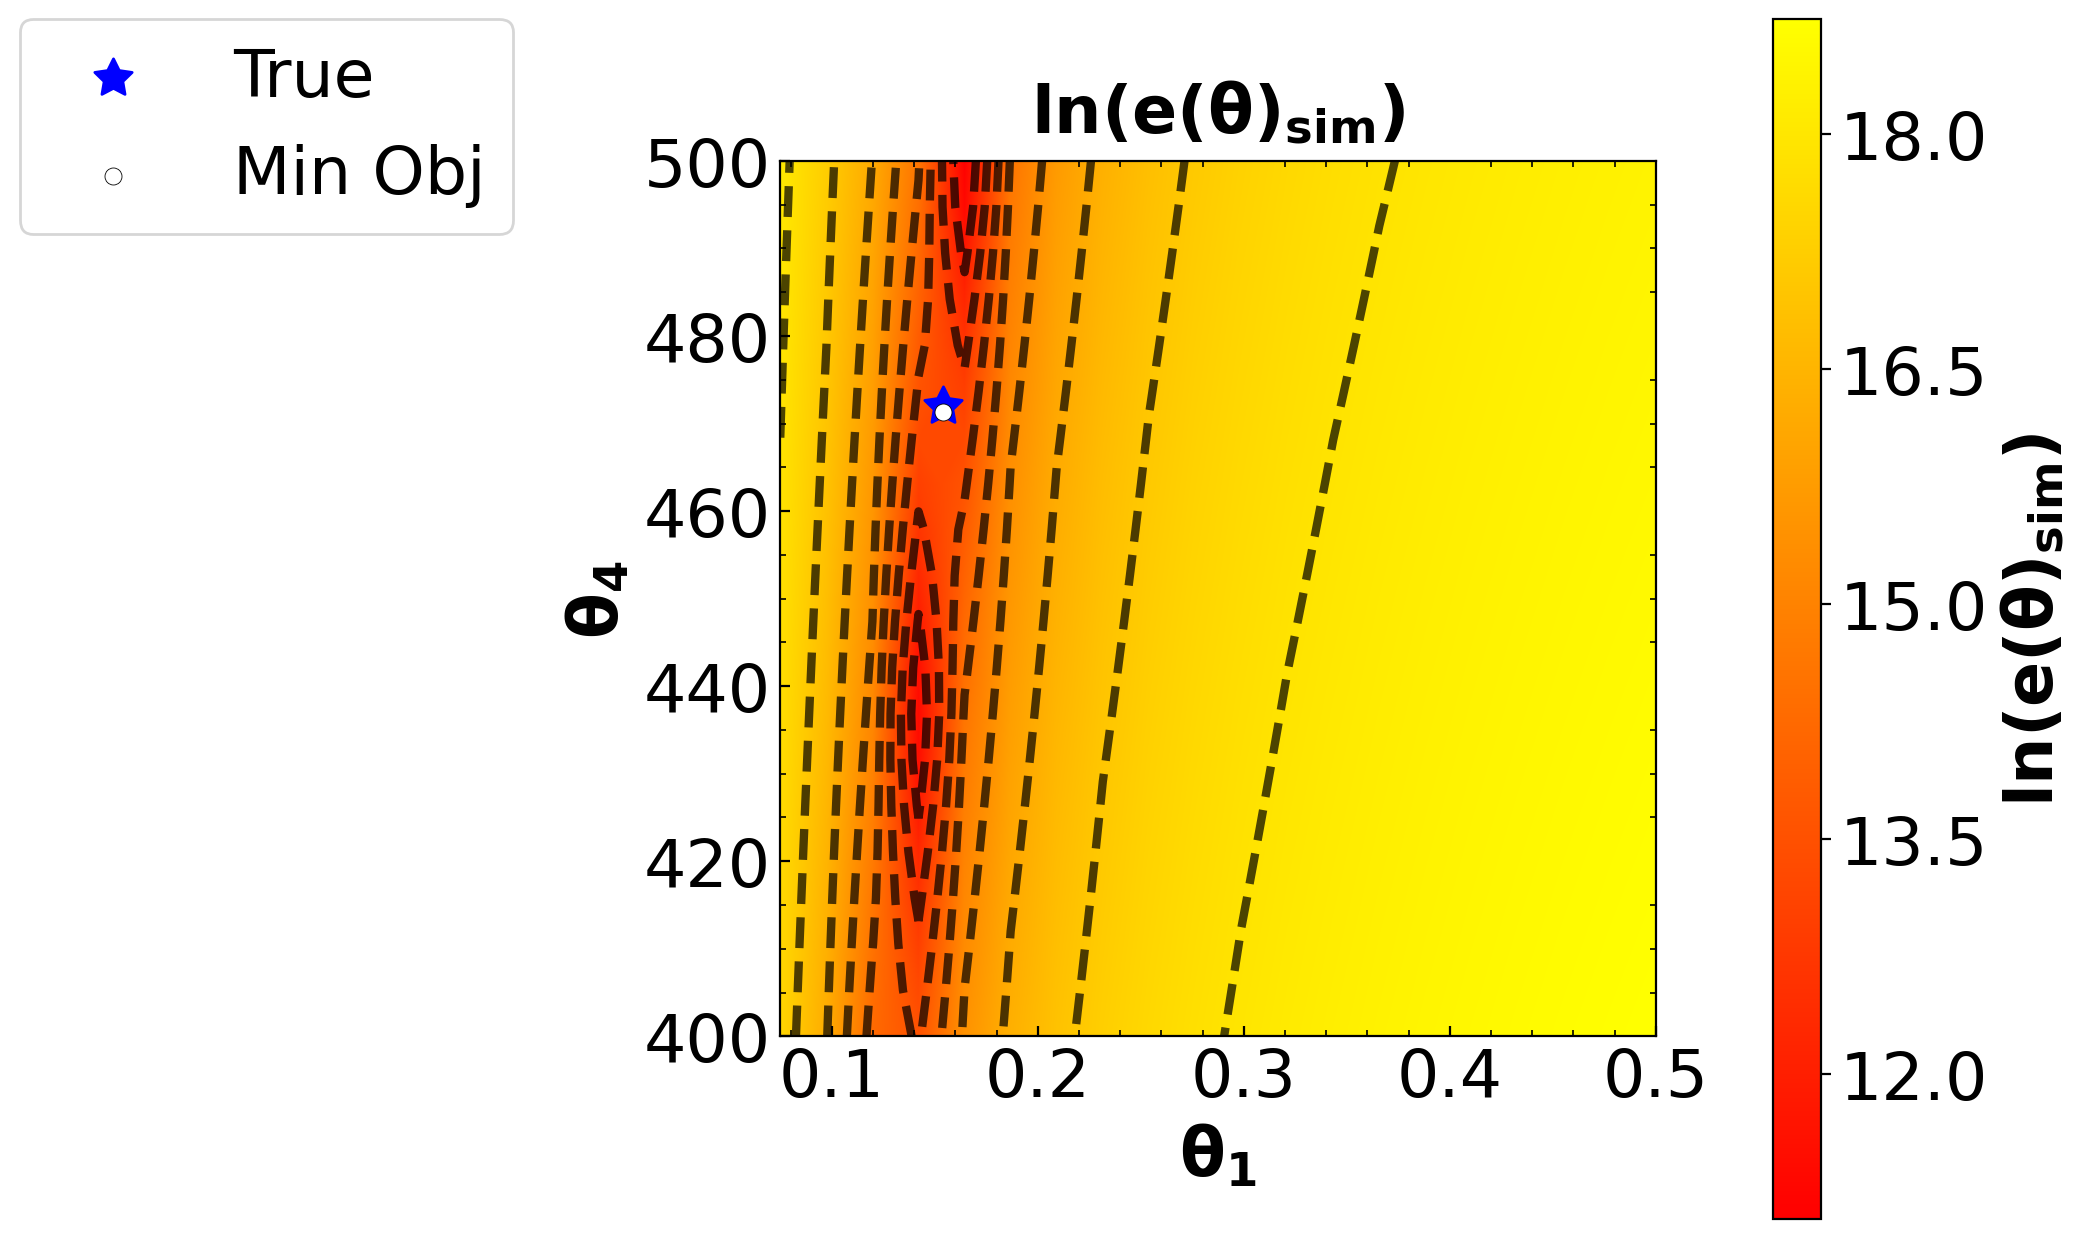

10.742652014211906 17.942797427403587


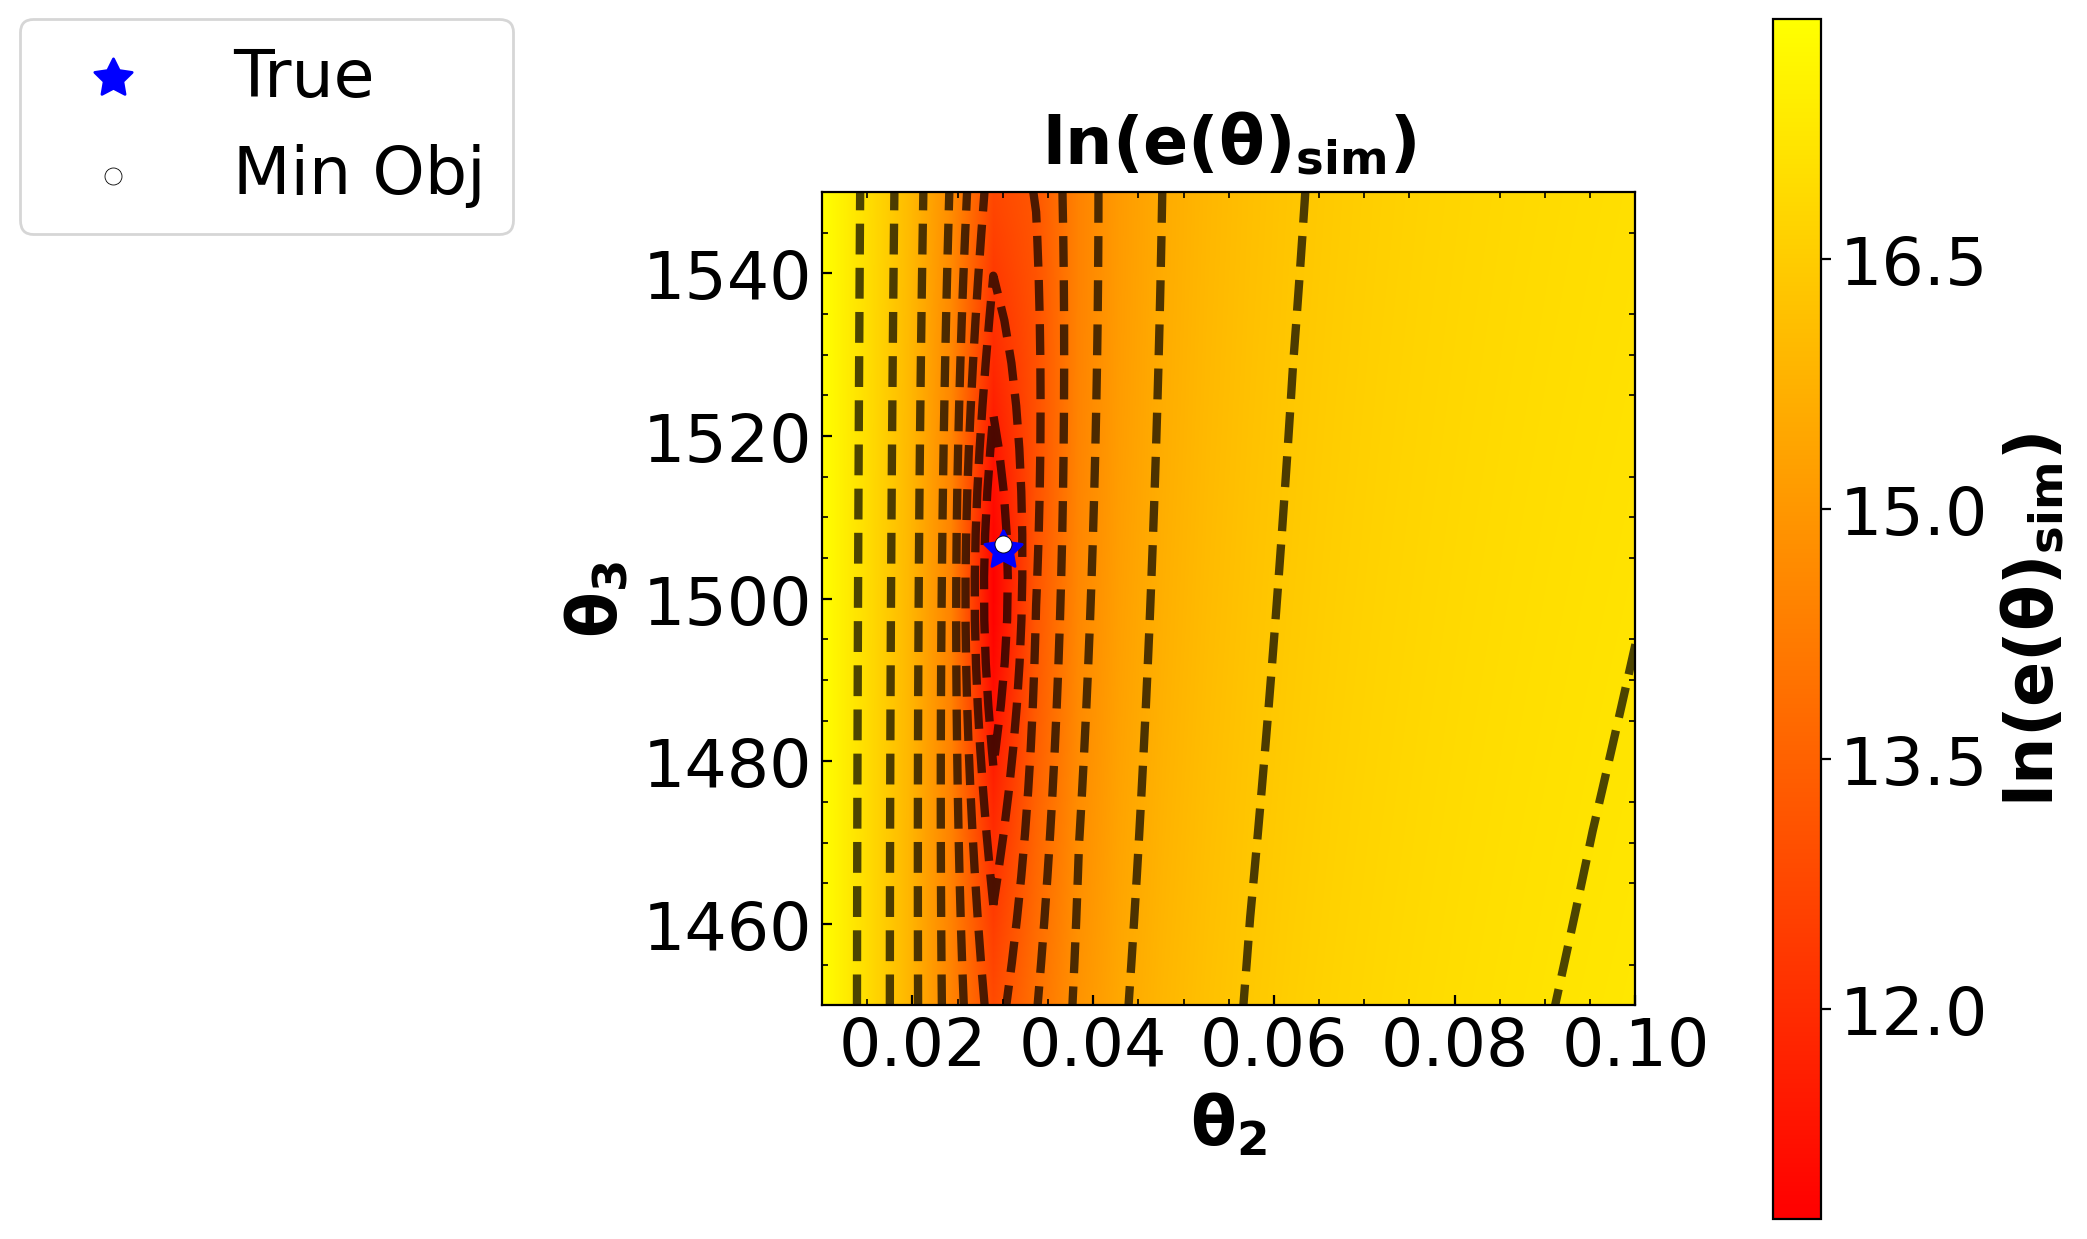

10.374141537348168 18.112703327540462


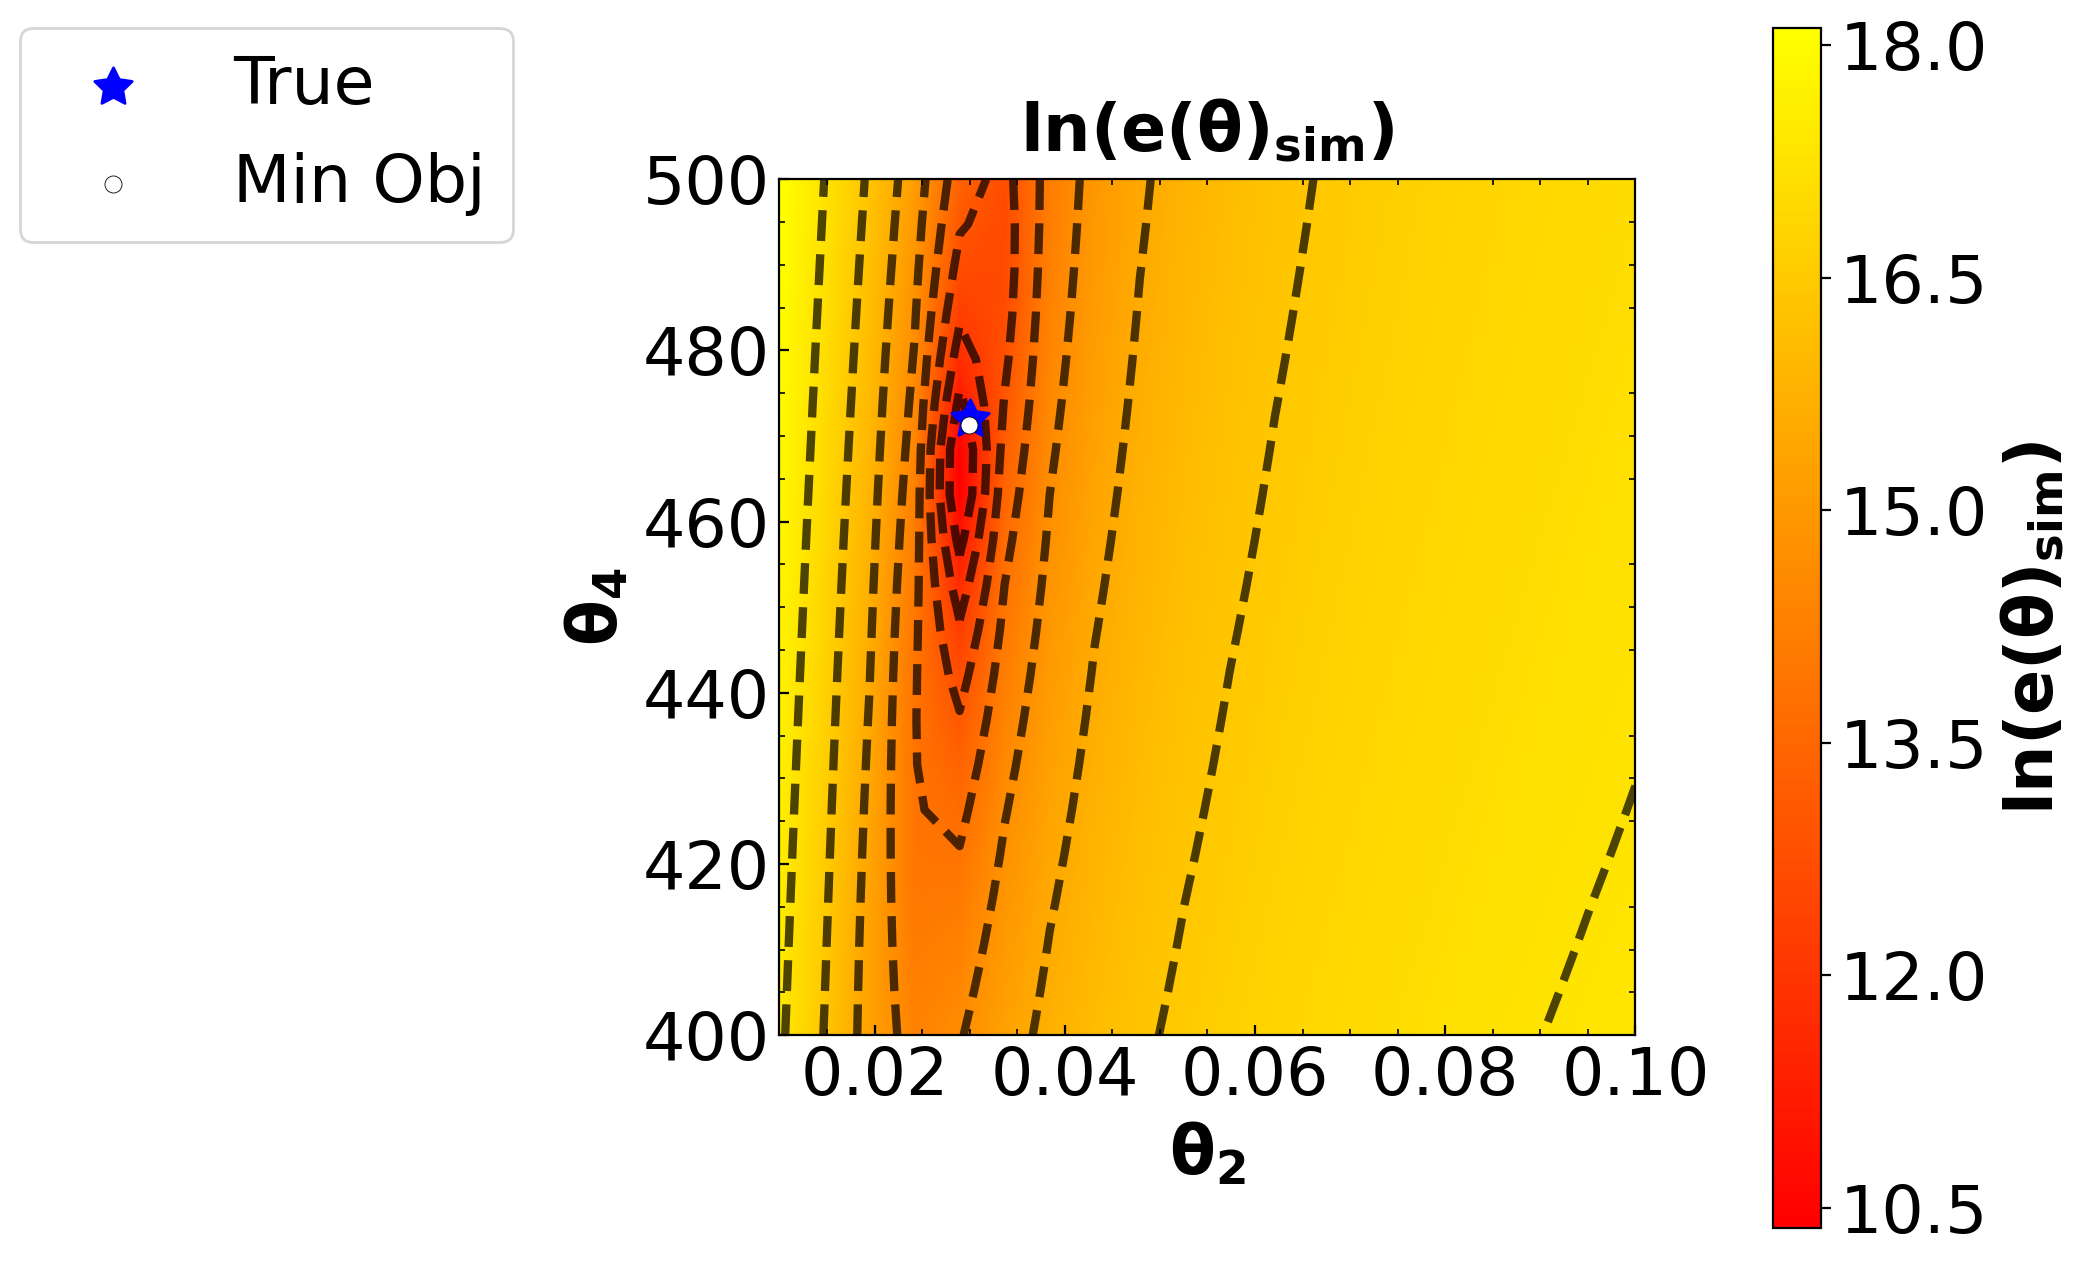

5.967032795198006 15.373960280058707


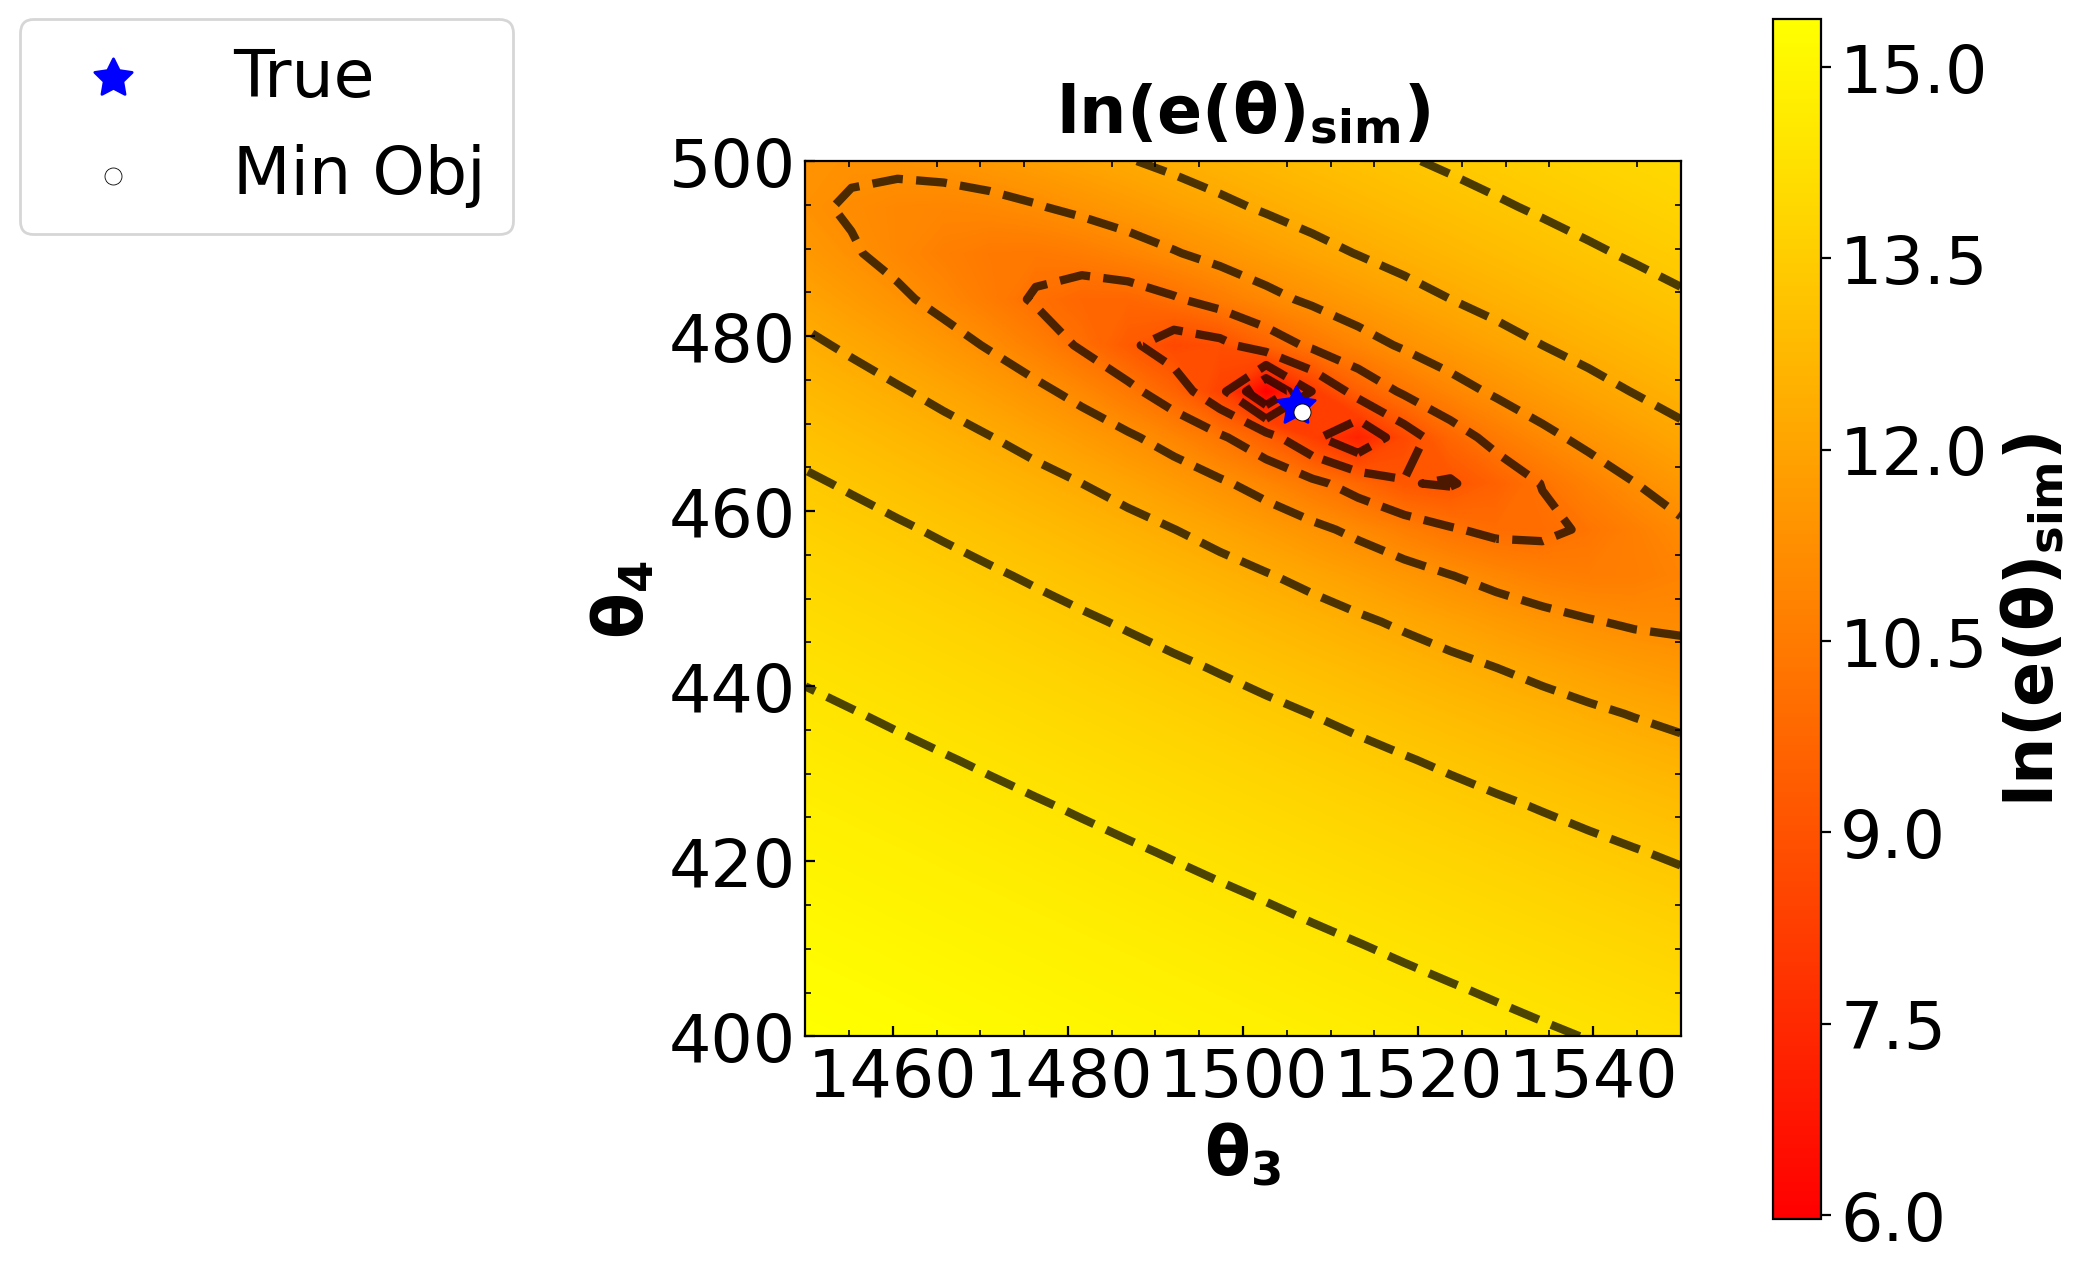

In [43]:
#New Cell
log_data = True
# save_figure = True
save_figure = False


#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp, Yexp)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]
    plot_dict = make_plot_dict(log_data, None, None, None, levels, save_path=None)
    plot_nlr_heat_maps(theta_mesh, z, theta_true, nlr_theta, z_titles, param_names, idcs_to_plot, plot_dict)

In [44]:
#Plot error
print("SSE = ", np.sum(error**2))

#Jacobian and Uncertainty Analysis
# print("Jacobian =\n")
# print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
# print("Covariance matrix:\n",Sigma_theta2)
print("Det(Covar) = ", np.linalg.det(Sigma_theta2))

SSE =  25.456373316711776
Det(Covar) =  2.3342427726249205e-22
